### Gene expression vs 3D changes during Legionella infection
**cmdoret**

In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. I use differential expression results from [Li et al. 2020](https://www.frontiersin.org/articles/10.3389/fcimb.2020.00428/full#h4), and have lifted over the neff v1 annotations they used to the C3 genome.
> Note: I allowed multi-mapping, which means a single C3 gene can match multiple Neff gene and vice versa.

In [7]:
import os
os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler

diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

In [9]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,517,5457,ID=gene:ACA1_272090;biotype=protein_coding;des...,ACA1_272090,Ras subfamily protein
40,scaffold_1,gene,6183,9815,ID=gene:ACA1_272100;biotype=protein_coding;des...,ACA1_272100,hypothetical protein
50,scaffold_1,gene,10749,11427,ID=gene:ACA1_272220;biotype=protein_coding;des...,ACA1_272220,hypothetical protein
60,scaffold_1,gene,30871,33218,ID=gene:ACA1_272240;biotype=protein_coding;des...,ACA1_272240,hypothetical protein
82,scaffold_1,gene,33329,33978,ID=gene:ACA1_272250;biotype=protein_coding;des...,ACA1_272250,hemerythrin hhe cation binding subfamily protein
...,...,...,...,...,...,...,...
213267,scaffold_90,gene,3593,4330,ID=gene:ACA1_374170;biotype=protein_coding;des...,ACA1_374170,hypothetical protein
213275,scaffold_90,gene,9190,9784,ID=gene:ACA1_374160;biotype=protein_coding;des...,ACA1_374160,hypothetical protein
213283,scaffold_93,gene,5734,6486,ID=gene:ACA1_045660;biotype=protein_coding;des...,ACA1_045660,hypothetical protein
213289,scaffold_93,gene,6787,6829,ID=gene:ACA1_263500;biotype=protein_coding;des...,ACA1_263500,polyprotein


In [10]:
print(f"{100* diff_expr.c3.isnull().sum() / diff_expr.shape[0]:.2f}% lifted-over genes had no match in my de-novo annotation pipeline")

20.75% lifted-over genes had no match in my de-novo annotation pipeline


<IPython.core.display.Javascript object>


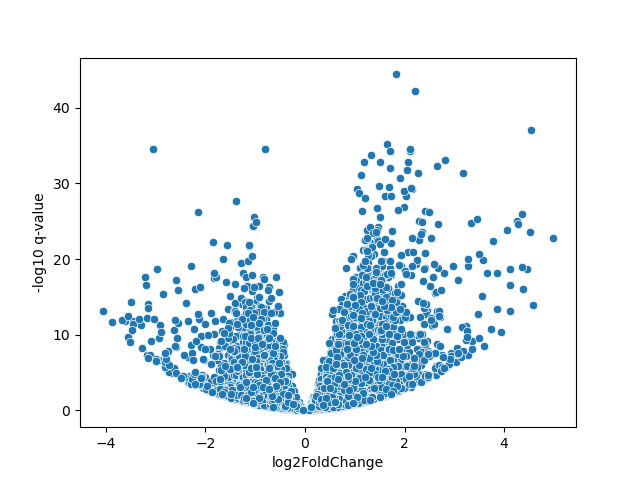

Text(0, 0.5, '-log10 q-value')

In [86]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")

Let's subset genes which are highly differentially expressed:


In [12]:
PADJ_THRESH = 0.05
L2FC_THRESH = 2

In [13]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [14]:
sig_expr = sig_expr.merge(liftover, on='accession', how='left').sort_values('padj')
sig_expr = sig_expr.dropna()
sig_expr.start = sig_expr.start.astype(int)
sig_expr.end = sig_expr.end.astype(int)
sig_expr = sig_expr.drop_duplicates(subset=['accession']).reset_index(drop=True)

In [15]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 241 genes (1.50%)  with more than 2 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, notably ACA1_153540. Let's have a look at these.

In [16]:
sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]


,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,chrom,type,start,end,attr,desc
15,ACA1_153540,1458.066017,4.365291,0.388818,11.227093,3.000000e-29,1.060000e-26,FUN_007560,scaffold_24,gene,875568,878213,ID=gene:ACA1_153540;biotype=protein_coding;des...,"transcriptional regulator, Sir2 family protein"


It is indeed in our top differentially expressed gene list. 

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.

> Note: All this will be done on the normalized and detrended matrix to correct for accessibility and genomic distance.

In [17]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/uninfected_merged_subsampled.cool')
clr_inf = cooler.Cooler('data/output/cool/infected_merged_subsampled.cool')

In [18]:
import itertools as it
import subprocess as sp
import tempfile
import shlex

def run_command(cmd: str):
    p = sp.Popen(shlex.split(cmd), bufsize=1, universal_newlines=True)
    return p.poll()

def get_contact_gene_pairs(cool_path: str, genes: pd.DataFrame, winsize=7) -> pd.DataFrame:
    """
    Compute contacts between all gene pairs.
    genes must have columns: chrom start end accession
    """
    # Generate all pairwise gene combinations and save as bed2d
    tmp_bed = tempfile.NamedTemporaryFile(delete=False)
    combs = pd.DataFrame((it.combinations(genes.accession, 2)))
    combs.columns = ['g1', 'g2']
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g1')
    combs = combs.merge(genes.loc[:, ['chrom', 'start', 'end', 'accession']], right_on='accession', left_on='g2')
    combs = combs.loc[:, ['chrom_x', 'start_x', 'end_x', 'chrom_y', 'start_y', 'end_y']]
    combs.to_csv(tmp_bed.name, sep='\t', header=False, index=False)
    
    # Run chromosight to extract windows of the Hi-C matrix at each inter-gene coordinate
    with tempfile.TemporaryDirectory() as chromo_dir:
        cmd = f'chromosight quantify --win-fmt=npy -t12 -z100 -I -W{winsize} {tmp_bed.name} {cool_path} {chromo_dir}/curr'
        !{cmd} # jupyter syntax. In regular python script use run_command function instead
    
        # Retrieve windows. We don't actually care about scores
        wins = np.load(chromo_dir + "/curr.npy")
        coords = pd.read_csv(chromo_dir + "/curr.tsv", sep='\t', usecols=range(6))
    
    # Annotate chromosight output with gene accessions
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('1'),
        on=['chrom1', 'start1', 'end1'],
        how='left',
    )
    coords = coords.merge(
        genes.loc[:, ['chrom', 'start', 'end', 'accession']].add_suffix('2'),
        on=['chrom2', 'start2', 'end2'],
        how='left',
    )
    # For each gene pair, add the mean contact value in the window as a column
    coords['mean_contacts'] = np.nansum(np.nansum(wins, axis=1), axis=1)/(wins.shape[0] * wins.shape[1])
    
    return coords

In [19]:
p_hic = get_contact_gene_pairs('data/output/cool/uninfected_merged_subsampled.cool', sig_expr)
p_hic = p_hic.rename(columns={'mean_contacts': 'ctl_contacts'})
p_hic['inf_contacts'] = get_contact_gene_pairs('data/output/cool/infected_merged_subsampled.cool', sig_expr)['mean_contacts']


max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22005 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpzd04m5rf/curr.pdf
max_perc_undetected set to 50.0 based on config file.
Matrix already balanced, reusing weights
Found 22020 / 22111 detectable bins
Preprocessing sub-matrices...
 [====================] 100.0% scaffold_36-scaffold_36[K
Sub matrices extracted
 [--------------------] 0.0% Kernel: 0
 [====================] 99.8% scaffold_36-scaffold_36Saving pileup plots in /tmp/tmpfs3iiqxt/curr.pdf


<IPython.core.display.Javascript object>


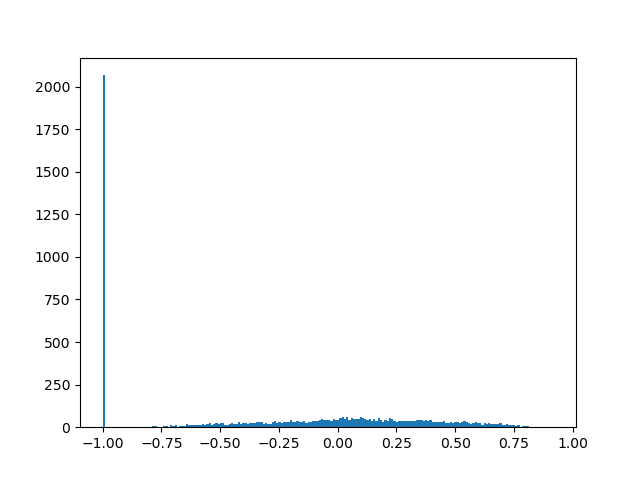

In [20]:
%matplotlib notebook
gene_space = p_hic.loc[(p_hic.ctl_contacts + p_hic.ctl_contacts) > 0, :]
f = plt.hist((gene_space.inf_contacts - gene_space.ctl_contacts) / (gene_space.inf_contacts + gene_space.ctl_contacts), 200)

In [21]:
gene_space

,chrom1,start1,end1,chrom2,start2,end2,accession1,accession2,ctl_contacts,inf_contacts
12,scaffold_2,109538,111834,scaffold_3,687169,688191,ACA1_372720,ACA1_321390,0.000005,0.000000
16,scaffold_32,166528,169071,scaffold_32,439518,439916,ACA1_035640,ACA1_182390,0.000006,0.000025
18,scaffold_4,1498893,1499857,scaffold_32,439518,439916,ACA1_310790,ACA1_182390,0.000003,0.000000
20,scaffold_3,687169,688191,scaffold_32,439518,439916,ACA1_321390,ACA1_182390,0.000006,0.000000
24,scaffold_4,1498893,1499857,scaffold_6,957551,958826,ACA1_310790,ACA1_282970,0.000009,0.000024
...,...,...,...,...,...,...,...,...,...,...
28865,scaffold_2,324904,326977,scaffold_2,2000767,2001277,ACA1_374380,ACA1_058430,0.000010,0.000000
28880,scaffold_2,1416464,1417130,scaffold_2,2000767,2001277,ACA1_061270,ACA1_058430,0.000013,0.000002
28897,scaffold_2,1146971,1149204,scaffold_2,2000767,2001277,ACA1_062090,ACA1_058430,0.000026,0.000004
28900,scaffold_2,1890563,1891305,scaffold_2,2000767,2001277,ACA1_059480,ACA1_058430,0.000011,0.000102


In [282]:
nnz_gene_pairs = gene_space.shape[0]
nnz_inter_pairs = gene_space.loc[gene_space.chrom1 != gene_space.chrom2, :].shape[0]
print(f'There are {nnz_gene_pairs} gene pairs with nonzero contacts (out of {pair_coords_inf.shape[0]}).'
      f' {nnz_inter_pairs} of these are interchromosomal'
)

There are 6733 gene pairs with nonzero contacts (out of 28920). 5795 of these are interchromosomal


In [83]:
"""
Next:
[x] 1. Retrieve matrix window for each pair of gene
[x] 2. Compute window average (detrended)
[x] 3. Repeat 1&2 for all 4 samples
[x] 4. Compute change estimator for each pair of gene (e.g. (c1r1+c1r2)/(c2r1+c2r2))
[ ] 5. Relate gene pairs with coexpression data
      a. Correlation between coexp and contact change gene pairs
      b. diff gene consistant direction ? down expr == down contact ?
"""


SyntaxError: invalid syntax (<ipython-input-83-fef12c03be3f>, line 1)

#### Co-variation of gene expression and 3D changes over time

I have formatted the data from Li et al to get the expression of each gene at each timepoint.
First, let's visualize the co-expression of all genes across the 4 time points.


In [23]:
expr_time = pd.read_csv('data/output/diff_expr/expr_vs_time.tsv', sep='\t')

In [24]:
#expr_time['expr'] = 2**expr_time.log2FoldChange *   expr_time.baseMean
expr_time['expr'] = expr_time['log2FoldChange']

In [125]:
def expr_to_corr(df):
    """Convert time vs expression df to correlation matrix"""
    mat = df.loc[:, ['accession', 'time', 'expr']].pivot('accession', 'time')
    mat.columns = mat.columns.get_level_values(1)
    mat.columns.name = None
    mat = mat.dropna(axis=0)
    corr = mat.transpose().corr().fillna(0)
    
    return corr

corr_mat = expr_to_corr(expr_time)


Here, I cluster genes along the co-expression matrix using hierarchical clustering

In [130]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

<IPython.core.display.Javascript object>


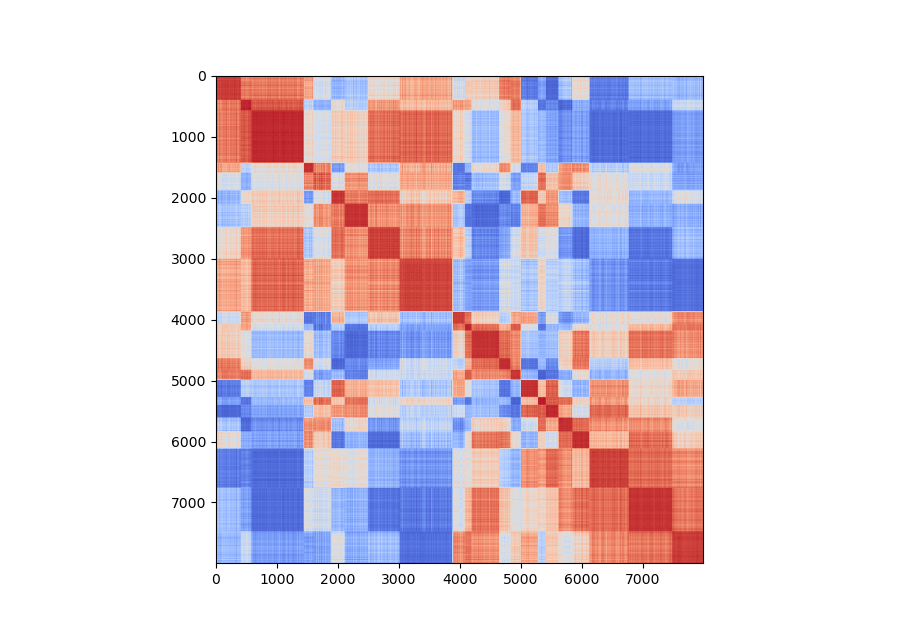

In [47]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_mat.iloc[:8000, :8000]), cmap='coolwarm', vmin=-1, vmax=1)

Here, I subset this dataset to include only genes that are significantly differentially expressed at the timepoint of interest. 

In [146]:
corr_sig = expr_to_corr(expr_time.loc[expr_time.accession.isin(sig_expr.accession)])
corr_sig.index = corr_sig.index.rename('accession1')
long_corr = corr_sig.stack().reset_index()
long_corr = long_corr.rename(columns={'accession': 'accession2', 0: 'coexpr'})

The co-expression matrix now looks much simpler. Looks like 4 gene clusters.

<IPython.core.display.Javascript object>


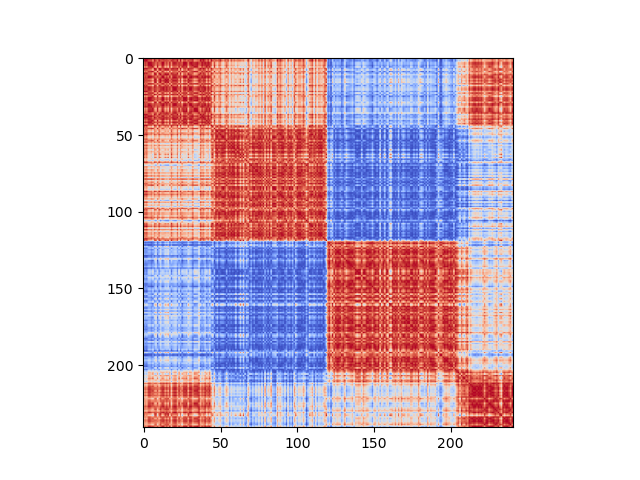

In [132]:
%matplotlib notebook
plt.imshow(cluster_corr(corr_sig), cmap='coolwarm')

Now let's plug in the Hi-C contact changes with co-expression data !

In [151]:
hic_rna = gene_space.merge(long_corr, on=['accession1', 'accession2'])
hic_rna['contacts_change'] = (hic_rna.inf_contacts - hic_rna.ctl_contacts) / (hic_rna.inf_contacts + hic_rna.ctl_contacts)

<IPython.core.display.Javascript object>


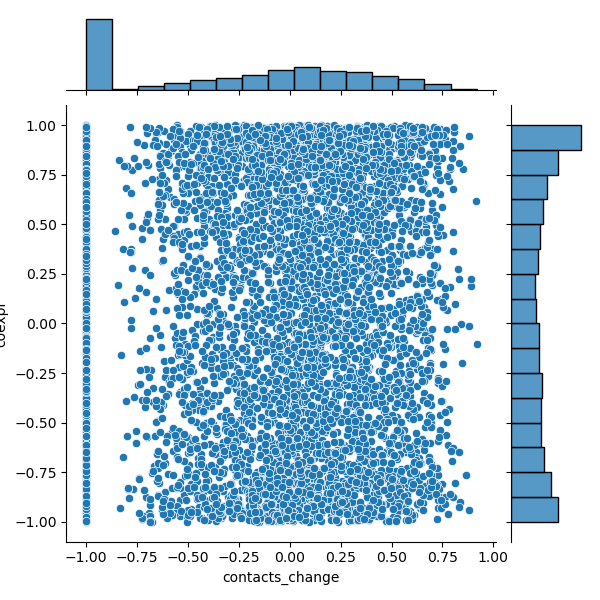

In [154]:
%matplotlib notebook
sns.jointplot(hic_rna.contacts_change, hic_rna.coexpr)

In [155]:
import scipy.stats as ss
ss.pearsonr(hic_rna.coexpr, hic_rna.contacts_change)

(-6.733714062824491e-05, 0.9955922577751037)

#### Unsupervised exploration of gene expression

<IPython.core.display.Javascript object>


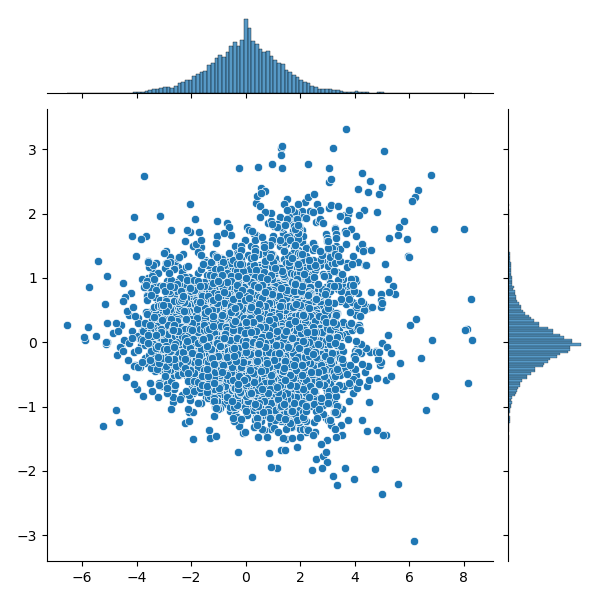

In [48]:
%matplotlib notebook
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA()
pcs = pca.fit_transform(expr_mat)
sns.jointplot(pcs[:, 0], pcs[:, 1])

In [57]:
import umap
um = umap.UMAP(n_neighbors=50)

embd = um.fit_transform(expr_mat)

<IPython.core.display.Javascript object>


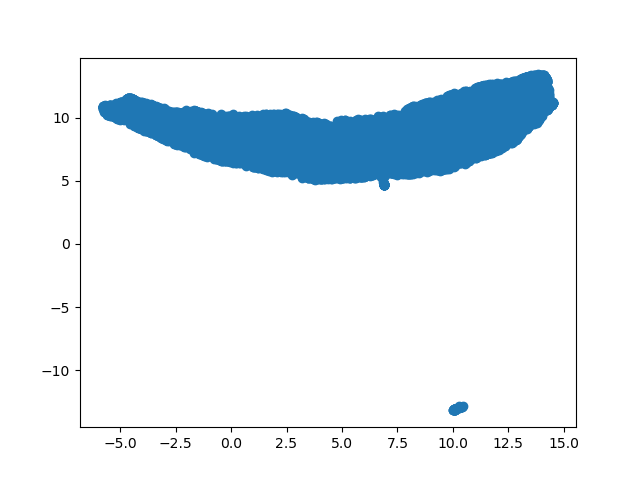

In [58]:
%matplotlib notebook
plt.scatter(embd[:, 0], embd[:, 1])

In [68]:
isolated_genes = np.where(embd[:, 1] < 0)[0]
isolated_names = expr_mat.iloc[isolated_genes, :].index.values
liftover.loc[liftover.accession.isin(isolated_names), :]

,chrom,type,start,end,attr,accession,desc
18894,scaffold_10,gene,813285,813521,ID=gene:ACA1_070310;biotype=protein_coding;des...,ACA1_070310,hypothetical protein
20216,scaffold_10,gene,1043662,1046264,ID=gene:ACA1_069420;biotype=protein_coding;des...,ACA1_069420,RhoGEF domain containing protein
43682,scaffold_14,gene,280896,281176,ID=gene:ACA1_377970;biotype=protein_coding;des...,ACA1_377970,hypothetical protein
45482,scaffold_14,gene,692534,694948,ID=gene:ACA1_110070;biotype=protein_coding;des...,ACA1_110070,"acetyltransferase, GNAT family"
57940,scaffold_16,gene,1169311,1170642,ID=gene:ACA1_254010;biotype=protein_coding;des...,ACA1_254010,hypothetical protein
59898,scaffold_17,gene,351656,352379,ID=gene:ACA1_224710;biotype=protein_coding;des...,ACA1_224710,universal stress domain containing protein
70934,scaffold_18,gene,1146599,1146811,ID=gene:ACA1_073840;biotype=protein_coding;des...,ACA1_073840,hypothetical protein
78522,scaffold_2,gene,5825,7171,ID=gene:ACA1_152400;biotype=protein_coding;des...,ACA1_152400,hypothetical protein
79580,scaffold_2,gene,223910,225189,ID=gene:ACA1_373940;biotype=protein_coding;des...,ACA1_373940,tetratricopeptide repeat domain containing pro...
101212,scaffold_21,gene,812315,813048,ID=gene:ACA1_275030;biotype=protein_coding;des...,ACA1_275030,hypothetical protein


<IPython.core.display.Javascript object>


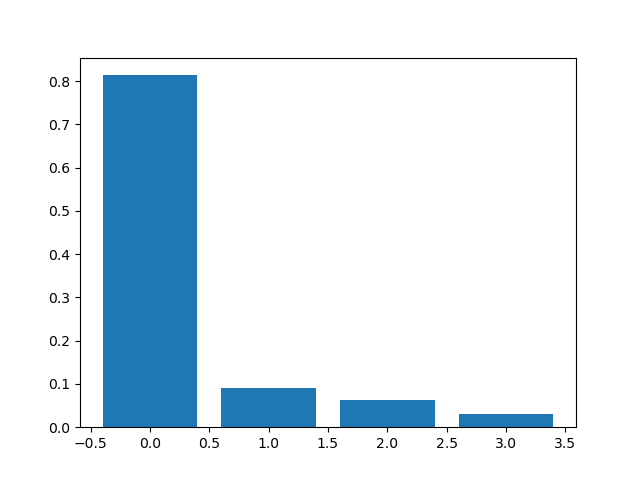

<BarContainer object of 4 artists>

In [137]:
%matplotlib notebook
plt.bar(range(pcs.shape[1]), pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


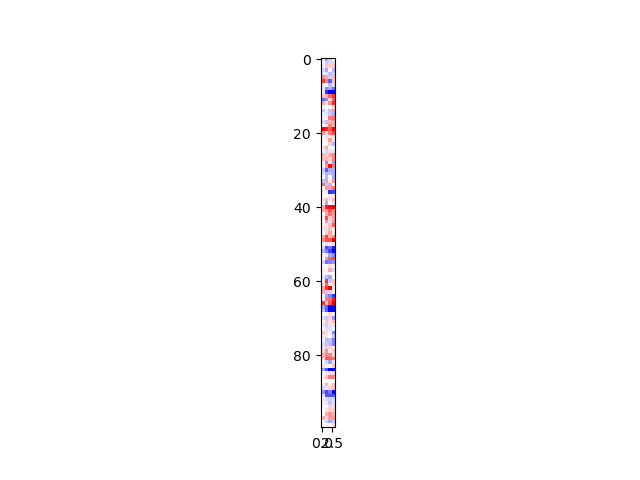

In [150]:
%matplotlib notebook
plt.imshow(expr_mat.to_numpy()[:100],cmap='bwr', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


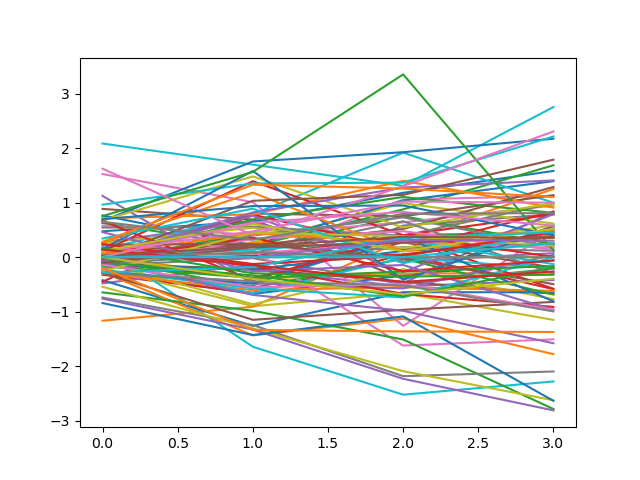

In [152]:
%matplotlib notebook
plt.plot(expr_mat.to_numpy()[:100].T)

#### Side note: Matrix around sirtuin gene sir6f

Below is an overview of the Hi-C contact map ratio of this gene's chromosome during infection.

In [31]:
import serpentine as serp
sir = sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]
sir_pos = clr_inf.extent(f'{sir.chrom.values[0]}:{int(sir.start.values[0])}-{int(sir.end.values[0])}')[0]
sir_pos -= clr_inf.extent(sir.chrom.values[0])[0]
sir_ctl = clr_ctl.matrix(balance=False).fetch(sir.chrom.values[0])
sir_inf = clr_inf.matrix(balance=False).fetch(sir.chrom.values[0])
sA, sB, sk = serp.serpentin_binning(sir_inf, sir_ctl, parallel=1, triangular=True)

2020-11-19 18:23:43.119351 Starting 10 binning processes...
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106470 (66.58744801275837 %)
2	 Total serpentines: 36715 (22.96194377560274 %)
3	 Total serpentines: 13272 (8.300447168454298 %)
4	 Total serpentines: 5607 (3.5066762562931926 %)
5	 Total serpentines: 3235 (2.0232027267894557 %)
6	 Total serpentines: 2528 (1.5810375558960568 %)
7	 Total serpentines: 2387 (1.4928546858876137 %)
8	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Total serpentines: 2373 (1.4840989399293287 %)
9	 Over: 2020-11-19 18:23:46.677558
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106431 (66.56305700616029 %)
2	 Total serpentines: 36734 (22.973826573688985 %)
3	 Total serpentines: 13239 (8.27980862440977 %)
4	 Total serpentines: 5602 (3.5035492041652336 %)
5	 Total serpentines: 3200 (2.0013133618937426 %)
6	 Total serpentines: 2515 (1.5729072203633634 %)
7	 Total serpentines: 2364 (1.4784702460990025 %)
8	 Total serpentines: 23

<IPython.core.display.Javascript object>


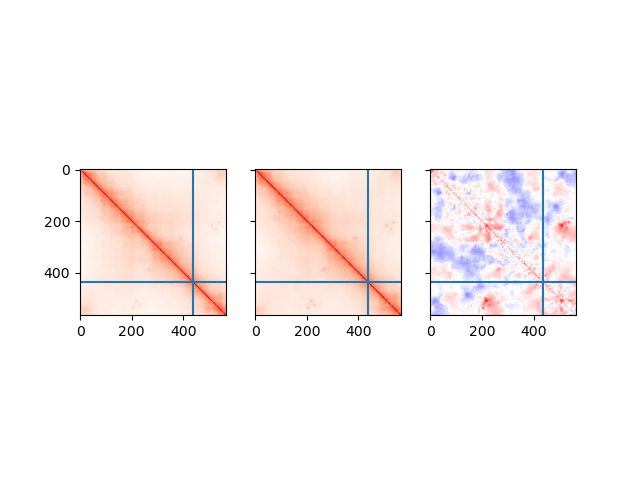

In [32]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(np.log(sA), cmap='Reds')
ax[1].imshow(np.log(sB), cmap='Reds')
ax[2].imshow(sk, cmap='bwr')
for i in range(3):
    ax[i].axvline(sir_pos)
    ax[i].axhline(sir_pos)


Now, we will compare differential looping results from pareidolia with differential expression data.

In [34]:
loops_diff = pd.read_csv(
    'data/output/pareidolia/loops_change_infection_time.tsv',
    sep='\t',
)
loop24 = loops_diff.loc[loops_diff.chrom1 == 'scaffold_24', :]
start24 = clr_inf.extent('scaffold_24')[0]
loop24.bin1 -= start24
loop24.bin2 -= start24

<IPython.core.display.Javascript object>


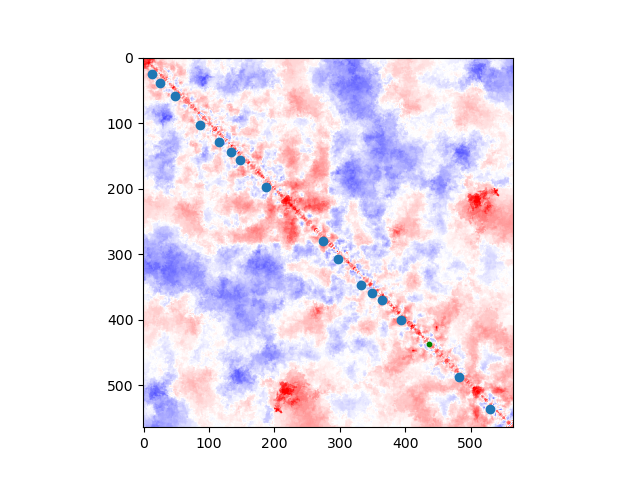

In [39]:
%matplotlib notebook
plt.imshow(sk - sk.mean(), cmap='bwr', vmin = -1, vmax=1)
plt.scatter(loop24.bin1, loop24.bin2)
s = clr_inf.extent('scaffold_24:875568-875568')[0] - start24
plt.scatter(s, s, s=10, c='green')